# 逻辑回归
  
回归，是指假设一个模型，设定一些参数，计算合适的参数以拟合逼近现有数据。

#### Linear Regression
$$h_\theta(x) = θ^Tx+θ_0$$
#### Logistic Regression
$$h_\theta(x) = g(θ^Tx+θ_0) = P(y=1|x,θ)$$
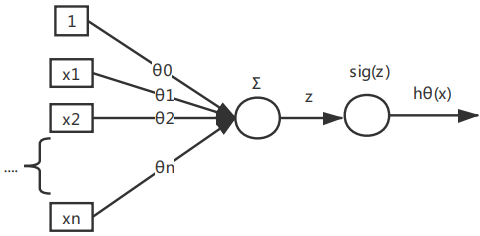


线性回归用一条直线模型去拟合数据，用来确定两种或两种以上变量间相互依赖的定量关系

逻辑回归计算样本属于某个标签的概率，构建一个分类边界，用来对数据进行二分类或者多分类。

上次实验我们用梯度下降训练了一个线性回归模型，这次我们实现一个逻辑回归模型来进行二分类的收入判断任务。

##### 注意事项：
本实验可能用到的函数：`np.mean`, `np.std`, `np.add`, `np.sum`, `np.mutual`, `np.dot`

本实验大部分变量为numpy array的数据类型，在计算时尽量化为numpy array类型进行计算

### 任务一：读取和预处理数据

第一步导入数据。压缩包中的train.csv中存储了原始数据，每人拥有年龄，工作类型等14个维度，共32561个样本。最后一个维度为本次实验的label，即收入是否大于50k。

做机器学习应用的时候很多时间是花费在特征处理上，我们注意到原始数据存在许多维度为非数字的数据，是不能直接用于构建模型的。我们可以通过离散化，把一个维度扩展到多个维度。如教育程度：（小学，初中，高中+）可以被扩展到如下三个维度：小学学历（是，否），初中学历（是，否），高中学历以上（是，否）。

经上述处理后的数据存储在X_train文件中，每个样本的维度被扩展到了106维，本实验直接使用X_train的数据构建模型。

In [1]:
import numpy as np 
from matplotlib import pyplot as plt

#X_train是前面所有的指标 Y_train是最后判断结果（01过程）
def getdata(X_train,Y_train):
    X = np.genfromtxt(X_train,delimiter=',',skip_header=1) #32561个样本*106个特征
    Y = np.genfromtxt(Y_train,delimiter=',',skip_header=1) #32561个label（0-1）
    #可以方便地从文本文件中-加载数据生成数组，并进行进一步的分析和处理
    #numpy.genfromtxt(fname, delimiter=None, dtype=float, filling_values=None, names=True)
    return X,Y #数组

def shuffle(X,Y):#单词-洗牌
    #打乱X,Y,避免数据存在初始的排序，影响训练效果
    randomize = np.arange(len(X)) #不同的库用的不太一样，返回的对象也不太一样。python自带的range()不支持numpy的shuffle
    #所以用arange，生成内容为索引 [0, 1, 2, ..., len(X)-1]
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize]) #ndarray的参数是数组时，返回一个依参数排序后的数组    

def train_test_split(X, Y, test_size=0.1314):
    #按一个比例分出一部分验证集
    train_len = int(round(len(X)*(1-test_size)))
    return X[0:train_len], Y[0:train_len], X[train_len:None], Y[train_len:None]#得到0-train_len这么多行的数据


X,Y = getdata('X_train','Y_train')
X, Y, X_test, Y_test = train_test_split(X, Y)

X.shape 
X[:1]

array([[3.9000e+01, 7.7516e+04, 1.0000e+00, 2.1740e+03, 0.0000e+00,
        4.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

### 任务二：数据归一化

归一化把每个特征的数据映射到0到1之间，消除指标之间的量纲影响，同时可以避免某些特征对模型预测结果的影响过大。

常用的归一化方法有两种：

一是利用最大最小值(min-max 归一化)；

二是利用平均值方差(z-score 0均值标准化)。

一般来说0均值标准化调整了数据的分布，使之更易于训练。

In [2]:
#???????????????????
def normalization(X):#归一化
    """将X中的数据映射到0-1之间
    参数：
        X:数据
    返回：
        归一化之后的X
    注意：
        测试在只归一化0,1,3,4,5,7,10,12,25,26,27,28列特征时，效果会比较好
        具体原因可探讨
    """    
    ### START THE CODE ###
# 对第 0,1,3,4,5,7,10,12,25,26,27,28列进行归一化
    columns_to_normalize = [0,1,3,4,5,7,10,12,25,26,27,28]
    X_normalized = (X[:, columns_to_normalize] - np.mean(X[:, columns_to_normalize], axis=0)) / np.std(X[:, columns_to_normalize], axis=0)

# 获取剩余的列
    other_columns = np.delete(X, columns_to_normalize, axis=1)

# 将归一化的结果与剩余的列拼接起来
    X_final = np.concatenate((X_normalized, other_columns), axis=1)
    
    ### END THE CODE ###
    
    return X_final
    
X = normalization(X)
X_test = normalization(X_test)

X[:1]

array([[ 0.02997349, -1.06586717,  0.14215522, -0.21607549, -0.03383413,
        -0.26256323, -0.1885562 ,  4.9041296 , -0.11434365, -0.69111392,
        -0.23540742, -0.03992059,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

### 任务三：完成sigmoid函数

sigmoid funtion函数原指曲线是 “S”形的函数，logistic function则指满足某个公式形式的一系列函数。
在机器学习中，其一般特指以下函数（standard logistic function）：
$$f(x) = \frac{1}{1+e^{-z}}$$

In [3]:
def sigmoid(z):
    """
    参数：
        z
    返回：
        sigmoid(z)
    """   
    ### START THE CODE ###
    s=1/(1+np.exp(-z));

    
    ### END THE CODE ###
    
    return np.clip(s, 1e-6, 1-1e-6)
    #clip:重要的处理，将超出范围的值强制置为边界值，避免y_pred为0，从而导致下面交叉熵损失无法计算
    #aeN: a*10的N次方
    
sigmoid(0.5)

0.6224593312018546

### 任务四：完成交叉熵损失函数
$$J(\theta)=-\frac{1}{m}\sum_1^m[y^ilog(h_\theta(x^i))+(1-y^i)log(1-h_\theta(x^i))]$$
损失函数用于评价模型预测同实际情况的差异，越小说明预测越准确。

概念上, 损失函数针对单个样本，代价函数针对总体。但作为优化目标时二者无不同。

交叉熵数学意义上衡量的是两个概率分布间的差异，本实验以交叉熵损失为优化目标函数。

In [4]:
def cost(y_pred, y_label, m):
    """代价函数，这里计算的是所有样本损失函数的和
    参数：
        y_pred：模型预测的值
        y_label：数据实际标签的值
        m：数据的样本数
    返回：
        cst: 预测值同标签值之间的代价
    """   
    ### START THE CODE ###
    #其中yi是真实的值，xi是真实值，h是什么？
    y_pred=np.mat(y_pred)
    y_label=np.mat(y_label).T
    
    one=np.ones((m,1))
    log1=np.log2(y_pred)
    cst=(np.dot(y_label.T,log1)+np.dot((one-y_label).T,np.log2(one-y_pred)))  *(-1/m)
    
    ### END THE CODE ###
    
    return cst[0,0]

cost([[0.4],[0.8]],[[0.6,0.1]],2) #numpy的log以e为底

1.6049355947431312

### 任务五：构建逻辑回归模型

$$\hat y=sig(θ_1*x_1+θ_2*x_2+...+θ_n*x_n+θ_0)$$

接下来先设置模型所需要的参数，可以自己修改观察对模型的影响。

对于样本的偏置θ0，有两种处理方法：
一种是作为一个维度添加到array θ上，相应样本也要添加一个值全为1的维度；

一种是单独拿出来更新，在梯度下降时分别处理。

本实验采取的是第二种方法。

最后完成模型所需的两个基本函数predict，和accuracy。

In [5]:
def predict(X, theta, theta_0):
    """预测
    参数：
        X：样本特征
        theta：权重参数 
        theta_0: 偏置参数
    返回：
        Y_pred: 样本的预测值 0~1
    """      
    ### START THE CODE ###
    X=np.mat(X)
    theta=np.mat(theta)

 
    t=np.dot(X,theta.T)
    y1=t+   np.broadcast_to(theta_0,np.shape(t))
    #print(y1)
    Y_pred=sigmoid(y1)
    ### END THE CODE ###
    
    return Y_pred

def accuracy(Y_hat, Y_label):
    """准确率
    参数：
        Y_hat：样本最终分类 0 or 1
        Y_label：样本标签
    返回：
        acc: 分类准确率
    """      
    ### START THE CODE ###
    count1=np.count_nonzero(Y_hat)
    count2=np.count_nonzero(Y_label)
    #2个与3个？
    #
    acc=1-np.abs(count1-count2)/np.size(Y_hat)

    
    ### END THE CODE ###
    
    return acc



predict([[0.4,0.8],[0.3,0.6]],[0.1,0.2],[0.15])

matrix([[0.58661758],
        [0.57444252]])

### 任务六：用随机梯度下降算法训练模型

全样本的梯度下降，在样本过大时，更新一次参数会需要巨大计算量。我们可以每次从中随机取出一定大小的样本，进行小批量随机梯度下降。
随机取样部分已完成，只需根据样本梯度下降更新参数即可。

根据我们的优化目标（默认为交叉熵），对损失函数求导，得到梯度计算公式为：
$$(h_\theta(x^i)-y)x^i$$
(推导见ppt)

θ，θ0更新时分别处理

In [6]:
def gradient_descent(x_bt, y_bt, theta, theta_0, learning_rate):
    
    
    """用每次取出的一个batch的数据训练模型,一个batch的意思是一小部分
    参数：
        x_bt:本次更新所用样本
        y_bt:本次更新样本的标签
        theta,theta_0：模型参数
    返回:
        theta:更新后的theta
        theta_0:更新后的theta_0
    过程：
        用theta,theta_0进行一次预测
        计算预测误差
        计算theta, theta_0各自的梯度，取均值
        用梯度更新theta_0和theta
    """ 
    ### START THE CODE ###
    m=x_bt.shape[0] #32
    predict_y=predict(x_bt,theta,theta_0)
    
    #loss=cost(predict_y,y_bt,m)
    #print(loss)
    y_bt=np.mat(y_bt).T
    
    gradient=np.dot(np.mat(predict_y-y_bt).T,x_bt) #结果应该是1*106


    
    theta=theta-learning_rate*gradient
    
    x_=np.ones((m,1))
    gradient0=np.dot(np.mat(predict_y-y_bt).T,x_)
    theta_0=theta_0-learning_rate*gradient0
    

    ### END THE CODE ###
    
    return theta,theta_0

gradient_descent(np.array([1]),np.array([1]),np.array([0.2]),np.array([0.1]),0.02)

(matrix([[0.20851115]]), matrix([[0.10851115]]))

In [7]:
#模型的基本参数：
theta = np.zeros(X.shape[1],) #106个权重参数，初值全为0
theta_0 = np.zeros(1,) #1个偏置参数，初值为0

#训练参数
max_iter = 80 #迭代次数
batch_size = 32 #随机梯度下降中每次取样个数
learning_rate = 0.0002 #学习率，可以尝试不同的学习率，如0.2、0.002、0.0002！！！！！！！！！！！！
num_train = len(Y)
num_test = len(Y_test)


def train(X, Y, theta, theta_0, max_iter, batch_size, learning_rate):
    #用于记录训练中损失和准确率的变化
    train_cost = [] ####
    test_cost = []
    train_acc = []
    test_acc = []

    for epoch in range(max_iter):
        X, Y = shuffle(X, Y) #随机打乱各行数据，这样参数不易陷入局部最优，模型能够更容易达到收敛。 
        for i in range(int(np.floor(len(Y)/batch_size))): #每个batch更新一次
            x_bt = X[i*batch_size:(i+1)*batch_size] #32个样本*106维
            y_bt = Y[i*batch_size:(i+1)*batch_size] #32个label
            
            #每个batch的样本更新参数theta,theta_0
            theta,theta_0 = gradient_descent(x_bt,y_bt,theta,theta_0,learning_rate)
            
        #记录每个epoch更新后，训练集上损失的变化和准确率的变化
        Y_pred = predict(X, theta, theta_0)
        #print("222"+np.shape(Y_pred))
        #print("111"+np.shape(Y))
        Y_hat = np.round(Y_pred)
        train_acc.append(accuracy(Y_hat, Y))
        train_cost.append(cost(Y_pred, Y, num_train))
        #记录每个epoch更新后，测试集上损失的变化和准确率的变化
        Y_test_pred = predict(X_test, theta, theta_0)
        Y_test_hat = np.round(Y_test_pred)
        test_acc.append(accuracy(Y_test_hat, Y_test))
        test_cost.append(cost(Y_test_pred, Y_test, num_test))
        
    return train_cost,test_cost,train_acc,test_acc
        
train_cost,test_cost,train_acc,test_acc = train(X, Y, theta, theta_0, max_iter, batch_size, learning_rate)      
len(train_cost)


80

### 任务七：观察模型在训练集和验证集上的表现

用matplotlib(plt)里的方法生成图表，观察随着迭代进行，模型损失和准确率的变化

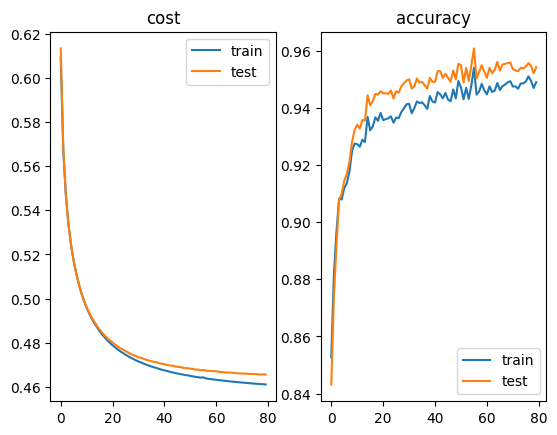

In [8]:
#子图1：损失
p1 = plt.subplot(121)
p1.plot(train_cost)
p1.plot(test_cost)
p1.legend(['train', 'test'])
p1.set_title("cost")

#子图2，准确率
p2 = plt.subplot(122)
p2.plot(train_acc)
p2.plot(test_acc)
p2.legend(['train', 'test'])
p2.set_title("accuracy")
plt.show()

### 样例输出：
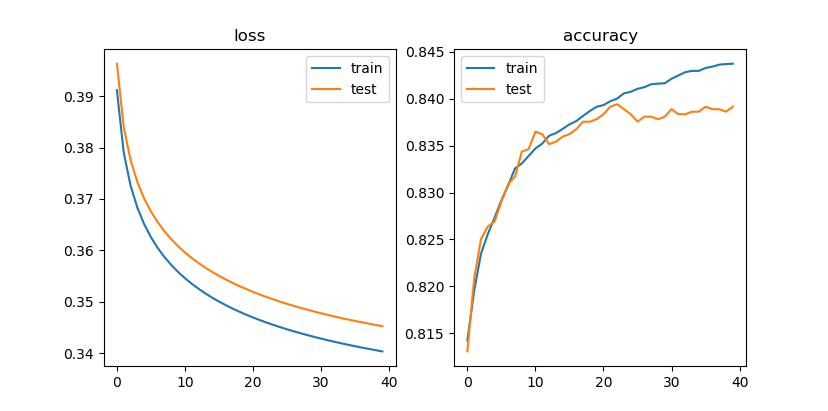

由于训练过程有一定随机性，训练结果可能存在不同